<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import libraries
Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import pandas as pd
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter


# for visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Discovering digitalStruct file

In [2]:
with open('SVHN/train/digitStruct.json') as f:
    data = json.load(f)
print(type(data))
print("sample data item:\n", data[0])
print("sample boxes:\n", data[0]['boxes'])
print("each item is of type: ", type(data[0]))
print("each item has 2 keys: ", data[0].keys())
print("each boxes is a", type(data[0]['boxes']), "of: ", len(data[0]['boxes']), type(data[0]['boxes'][0]))
print("first dict has ", data[0]['boxes'][0].keys())
print("second dict has ", data[0]['boxes'][1].keys())
for i in range(len(data)):
    data[i]['filename'] = 'train/'+data[i]['filename']

<class 'list'>
sample data item:
 {'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
sample boxes:
 [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]
each item is of type:  <class 'dict'>
each item has 2 keys:  dict_keys(['filename', 'boxes'])
each boxes is a <class 'list'> of:  2 <class 'dict'>
first dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])
second dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])


## Import Pics with labels

In [3]:
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    images = np.array(images)
    labels = np.array(labels)
    boxes = np.array(boxes)
    return images, labels, boxes

In [17]:
train_images, train_labels, train_boxes = getPics("test")


There are  13068  images in test set.


In [5]:
train_images = train_images[:1000]
train_labels = train_labels[:1000]
train_boxes = train_boxes[:1000]
print(train_boxes[0])

[{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]


- Calculating images median and mean resolution

In [6]:
sizes = []
for img in train_images:
    sizes.append(img.shape[0]*img.shape[1])
imgs_median_size = statistics.median(sizes)
imgs_mean_size = statistics.mean(sizes)

print("Average image size is:", imgs_mean_size)
print("Median image size is:", imgs_median_size)
print("Min image size is:", min(sizes))
print("Max image size is:", max(sizes))
# plt.hist(sorted(sizes))
plt.show()

Average image size is: 10437.495
Median image size is: 4795.5
Min image size is: 390
Max image size is: 375804


In [7]:
def iouPicTest(truth, predicted, threshold1=0.5, threshold2=0.5):
    filtered = []
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = torch.tensor(
                [[truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'],
                  truth[i]['top']+truth[i]['height']]], dtype=torch.float)
            predicted_box = torch.tensor(
                [[predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'],
                  predicted[j]['top']+predicted[j]['height']]], dtype=torch.float)
            x = ops.box_iou(truth_box, predicted_box)
            if (x >= threshold1):
                # print([x, predicted_box])
                filtered.append([float(x), predicted[j]])

    filtered = sorted(filtered, key=itemgetter(0), reverse=True)
    i=0
    acc = 0
    iou = []
    if len(filtered) > 0:
        while i < len(filtered) and filtered[i][0] != 0 :
            for j in range(i+1, len(filtered)):
                predicted_box1 = torch.tensor(
                [[filtered[i][1]['left'], filtered[i][1]['top'], filtered[i][1]['left']+filtered[i][1]['width'],
                  filtered[i][1]['top']+filtered[i][1]['height']]], dtype=torch.float)
                predicted_box2 = torch.tensor(
                [[filtered[j][1]['left'], filtered[j][1]['top'], filtered[j][1]['left']+filtered[j][1]['width'],
                  filtered[j][1]['top']+filtered[j][1]['height']]], dtype=torch.float)
                if (ops.box_iou(predicted_box1, predicted_box2)) >= threshold2:
                    filtered[j][0]= 0
            i+=1
            filtered = sorted(filtered, key=itemgetter(0), reverse=True)
        cnt=0
        for i in range(len(filtered)):
            if (filtered[i][0]==0):
                break
            cnt+=1
            iou.append(filtered[i][0])
        filtered = filtered[:cnt]
        acc = np.average(np.array(iou))
    return acc, filtered
    

## Model that get rectangles

In [8]:
def rectanglesModel(img):
    image = img.copy()
    boxes = []
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    cv2.convertScaleAbs(gray, gray)

    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    th3 = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

    edged = cv2.Canny(th3, 50, 150, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        boxes.append({})
        boxes[i]['left'], boxes[i]['top'], boxes[i]['width'], boxes[i]['height'] = cv2.boundingRect(contours[i])

    # cnts_a = []
    # for c in cnts:
    #     cnts_a.append(cv2.contourArea(c))
    # cnts_m = np.percentile(cnts_a,60)
    # for i in range(len(cnts)):
        # x, y, w, h = cv2.boundingRect(c)
        # if ( img_res < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50) or (image.shape[0] < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50):
        #     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # if(cnts_a[i]>cnts_m):
        #     hull = cv2.convexHull(cnts[i])
        #     cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)
    return boxes


In [9]:
def showRectangles(image, rectangles, title=""):
    image2 = image.copy()
    for i in rectangles:
        cv2.rectangle(image2, (i['left'], i['top']), (i['left'] +
                      i['width'], i['top']+i['height']), (0, 255, 0), 1)
    plt.figure()
    plt.title(title)
    plt.imshow(image2)


In [10]:
i = 0
image = train_images[i].copy()
predicted_boxes = rectanglesModel(image)
true_boxes = train_boxes[i]
accuracy, ret = (iouPicTest(true_boxes,predicted_boxes))
print(accuracy)


0


In [11]:
def getAccuracy(idx):
    image = train_images[idx].copy()
    predicted_boxes = rectanglesModel(image)
    true_boxes = train_boxes[idx]
    accuracy, ret = (iouPicTest(true_boxes,predicted_boxes))
    return accuracy

In [12]:
def getAllAccuracy():
    all_accuracy = []
    for i in range(len(train_images)):
        all_accuracy.append(getAccuracy(i))
    acc = np.average(np.array(all_accuracy))
    return acc

In [18]:
all_acc = getAllAccuracy()
print(all_acc*100, "%")

45.055320488022744 %


In [19]:
print(all_accuracy)

NameError: name 'all_accuracy' is not defined

## Model that visualize biggest convex hull

In [ ]:
def hullModel(img):
    image = img.copy()
    g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(g, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    hulls = []
    for i in range(len(contours)):
        hulls.append(cv2.convexHull(contours[i]))
        # cv2.drawContours(toDraw, [hull], 0, (0, 255, 0), 1)
    return hulls


In [ ]:
i=0
print("Label: ", train_labels[i])
plt.figure("Original")
plt.imshow(train_images[i])
plt.figure("Hull Model")
hulls = hullModel(train_images[i])
for j in range(len(hulls)):
    toDraw = train_images[i].copy()
    cv2.drawContours(toDraw, [hulls[j]], 0, (0, 255, 0), 1)
plt.imshow(toDraw)

# plt.imshow(ans)


-----------------------------------------------------------------------

- View sample image

sample train image of lable(s):  [2. 3.]


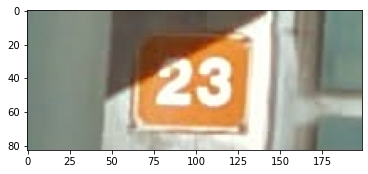

In [88]:
i = 1
print("sample train image of lable(s): ",train_labels[i] )
plt.imshow(train_images[i])
plt.show()

- Convert to grayscale

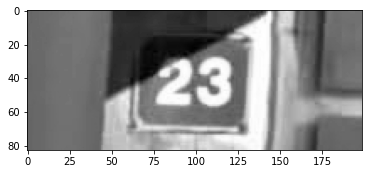

In [89]:
gray = cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

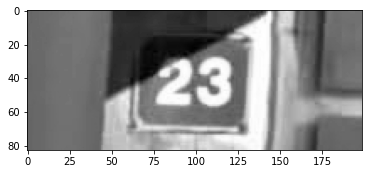

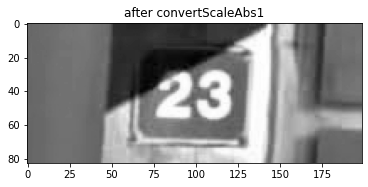

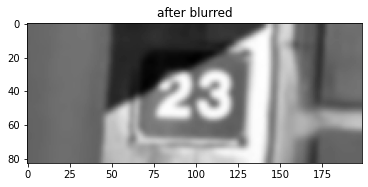

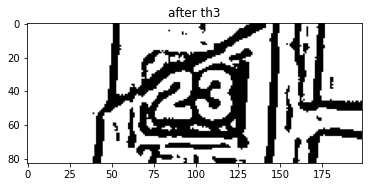

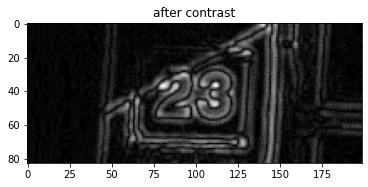

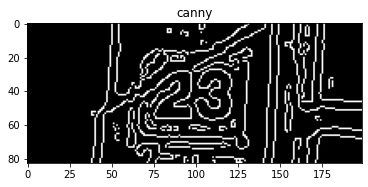

In [97]:
plt.imshow(gray, cmap='gray')
plt.show()

cv2.convertScaleAbs(gray, gray)
plt.figure()
plt.imshow(gray, cmap='gray')
plt.title("after convertScaleAbs1")
plt.show()


blurred = cv2.GaussianBlur(gray, (7, 7), 0)
plt.figure()
plt.imshow(blurred, cmap='gray')
plt.title("after blurred")
plt.show()

th3 = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.figure()
plt.imshow(th3, cmap='gray')
plt.title("after th3")
plt.show()

sharpened = cv2.convertScaleAbs(cv2.Laplacian(blurred, cv2.CV_16S, ksize=3))
plt.figure()
plt.title("after contrast")
plt.imshow(sharpened, cmap='gray')
plt.show()

edged = cv2.Canny(th3, 50, 150, 255)
plt.figure()
plt.title("canny")
plt.imshow(edged, cmap='gray')
plt.show()

# lines = cv2.HoughLines(edged, 1, np.pi/180, 30)

# temp = np.zeros((gray.shape[0], gray.shape[1], 3))
# for rho,theta in lines[0]:
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))

#     cv2.line(temp,(x1,y1),(x2,y2),(0,0,255),2)
# plt.figure()
# plt.title("hough")
# plt.imshow(temp, cmap='gray')
# plt.show()

# temp = np.zeros((gray.shape[0], gray.shape[1], 3))
# linesP = cv2.HoughLinesP(sharpened,1,np.pi/180,50, None,10,1)
# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         cv2.line(temp, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)

# plt.figure()
# plt.title("hough2")
# plt.imshow(temp)
# plt.show() 

# contours, hierarchy = cv2.findContours(
#     edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)
# for i in range(10):
#     temp = np.zeros((gray.shape[0], gray.shape[1], 3))
#     cv2.drawContours(temp, contours[i], -1, (255, 255, 255), 1)
#     plt.figure()
#     plt.title("after edges")
#     plt.imshow(temp, cmap='gray')
#     plt.show()


- Gaussian blur

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

- Canny edge detection

In [ ]:
edged = cv2.Canny(gray, 20, 100, 255)
edged_smoothed = cv2.GaussianBlur(edged, (5, 5), 0)

plt.imshow(edged_smoothed, cmap='gray')
plt.show()


- Finding countours

In [ ]:
contours, hierarchy  = cv2.findContours(edged_smoothed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
x = np.zeros((edged.shape[0], edged.shape[1], 3))
for i in range(len(contours)):
    temp = np.zeros((edged.shape[0], edged.shape[1], 3))
    cv2.drawContours(temp, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    cv2.drawContours(x, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    plt.imshow(temp)
    plt.show()
plt.imshow(x)
plt.show()
x = cv2.convexHull(contours)
plt.imshow(x)
plt.show()

In [ ]:
# find contours in the edge map, then sort them by their size in descending order
# cnts = imutils.grab_contours(contours)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
img = train_images[i].copy()
i = 0

for j in cnts:
    if (cv2.isContourConvex(j) and i < 4):
        img = cv2.drawContours(img, j, -1, (0, 255, 75), 2)
        print(cv2.contourArea(j))
        i += 1
plt.imshow(img)
plt.show()

# displayCnt = None
# loop over the contours
# for c in cnts:
# 	# approximate the contour
# 	peri = cv2.arcLength(c, True)
# 	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
# 	# if the contour has four vertices, then we have found the thermostat display
# 	if len(approx) == 4:
# 		displayCnt = approx
# 		break


In [ ]:
i = 2
print("sample cropped train image of lable(s): ",cropped_train_labels[i] )
plt.imshow(cropped_train_images[i])
plt.show()

In [ ]:
gray = cv2.cvtColor(cropped_train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

In [ ]:
edged = cv2.Canny(blurred, 40, 100, 255)
plt.imshow(edged, cmap='gray')
plt.show()

In [ ]:
for i in range(10):
    plt.imshow(cropped_train_images[i, :, :, :])
    plt.show()
    print(cropped_train_labels[i])